In [2]:
from gappyfpca.fpca import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# generate synthetic dataset to test

# Parameters
M = 1000  # Number of functions
L = 50   # Length of each function

# Sinusoidal patterns with random frequencies and phases
x = np.linspace(0, 2 * np.pi, L)
functions = np.array([10+np.random.uniform(0.1, 5)*np.sin(x * np.random.uniform(1, 1.5) + np.random.uniform(0,  np.pi/2)) 
                      for _ in range(M)])

# Random polynomials
#functions = np.array([np.polyval(np.random.uniform(-1, 1, size=3), np.linspace(-1, 1, L)) 
#                      for _ in range(M)])

data=np.copy(functions)
#artifically gappy it
for i in range(M):
    # Determine the number of NaNs to insert (0 to <50% of the function length)
    num_nans = np.random.randint(0, L // 2)  
    # Randomly select indices to replace with NaN
    nan_indices = np.random.choice(L, num_nans, replace=False)
    # Replace selected indices with NaN
    data[i, nan_indices] = np.nan



In [4]:
# Generate fpca of full data using

fpca_comps,fpca_coefs,evalue,run_stat=gappyfpca(data,0.95,max_iter=15,num_iter=5,iparallel=0)

Step 1, time: 0.690150260925293
Iteration  1
Time:  0.7153716087341309
Iteration  2
Time:  0.7140190601348877
Iteration  3
Time:  0.6772260665893555
Iteration  4
Time:  0.7100648880004883
Iteration  5
Time:  0.786168098449707


In [5]:
# Impute missing data

function_recon=reconstruct_func(fpca_comps[0,:],fpca_comps[1:,:],fpca_coefs)


0.0792875739535447 0.10033025946348811


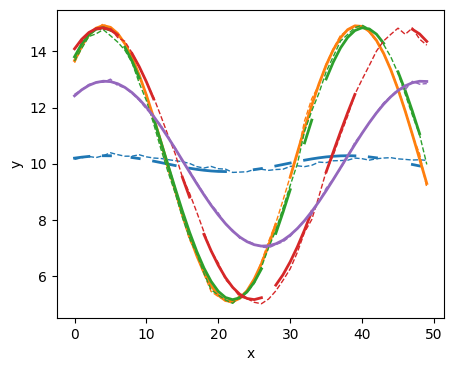

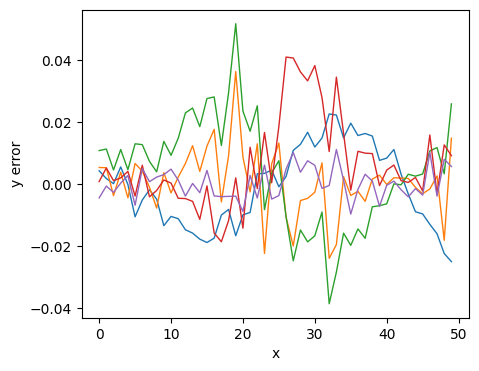

In [6]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
colors = plt.cm.tab10.colors
for i in range(5):
    ax.plot(data[i,:],linestyle='-',linewidth=2,color=colors[i])
    ax.plot(function_recon[i,:],linestyle='--',linewidth=1,color=colors[i])
ax.set_xlabel('x')
ax.set_ylabel('y')

fig,ax=plt.subplots(1,1,figsize=(5,4))

for i in range(5):
    ax.plot((functions[i,:]-function_recon[i,:])/functions[i,:],linestyle='-',linewidth=1,color=colors[i])
ax.set_xlabel('x')
ax.set_ylabel('y error')

missing_data=functions[np.isnan(data)]
print(np.mean(np.abs((functions-function_recon))),np.mean(np.abs(functions[np.isnan(data)]-function_recon[np.isnan(data)])))